In [46]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

### Importar datos

In [47]:
df_a = pd.read_csv('sociocom_unico.csv')

In [48]:
df_a.drop('Unnamed: 0', axis = 1, inplace=True)
df_a = df_a.set_index('pk_cid')

In [49]:
df_a.head(5).T

pk_cid,15891,16063,16203,16502,17457
pk_partition,2018-08-28,2019-05-28,2019-05-28,2019-05-28,2019-05-28
entry_date,2018-07-28,2018-11-19,2018-12-23,2018-09-30,2017-09-16
entry_channel,KAT,KAT,KAT,KHN,KAT
active_customer,0.0,0.0,1.0,1.0,1.0
segment,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES
country_id,ES,ES,ES,ES,ES
region_code,28.0,28.0,8.0,28.0,28.0
gender,H,H,V,H,H
age,59,62,70,58,54
deceased,N,N,N,N,N


In [50]:
# Quitamos los fallecidos
df_a= df_a[df_a['deceased'] != 'S']

In [51]:
# eliminamos los que nos nos interesan
df_a.drop(['entrada_año','entrada_mes','entrada_mes_año','entry_date','country_id','pk_partition','deceased','salary','entry_channel','active_customer','segment','gender','region_code'],axis=1,inplace=True)

In [52]:
#Vamos a hacer binning con varias variables continuas

# EDAD
# Definimos los límites de los bins y las etiquetas para las categorías
bins = [0, 25, 65, float('inf')]
labels = ['1-estudiantes', '2-trabajadores', '3-jubilados']

# Aplicar el binning usando pd.cut
df_a.age = pd.cut(df_a.age, bins=bins, labels=labels, right=False)

# ANTIGUEDAD
# Definimos los límites de los bins y las etiquetas para las categorías
bins = [0, 365, float('inf')]
labels = ['1-Nuevo', '2-Antiguo']

# Aplicar el binning usando pd.cut
df_a.antiguedad = pd.cut(df_a.antiguedad, bins=bins, labels=labels, right=False)





In [53]:
df_a.head(5).T

pk_cid,15891,16063,16203,16502,17457
age,2-trabajadores,2-trabajadores,3-jubilados,2-trabajadores,2-trabajadores
antiguedad,1-Nuevo,1-Nuevo,1-Nuevo,1-Nuevo,2-Antiguo


In [54]:
df_b = pd.read_csv('variables_productos_final.csv')

In [55]:
df_b.drop(['Unnamed: 0','promedio_cuentas','baja_algunavez'],axis=1,inplace=True)

In [56]:
# suma por tipo de producto
df_b['ahorro_inversion'] = df_b[['short_term_deposit','funds','securities','long_term_deposit','pension_plan']].sum(axis=1)
df_b['financiacion'] = df_b[['loans','mortgage','credit_card']].sum(axis=1)
df_b['servicios'] = df_b[['em_account_pp','payroll_account','payroll','debit_card','emc_account','em_account_p','em_acount']].sum(axis=1)

In [57]:
# nos quedamos con las sigueintes variables para el clustering
listilla = ['pk_cid','TOTAL_ultima_imagen','ahorro_inversion','financiacion','servicios']

# eliminamos
df_b = df_b[listilla]

In [58]:
# Creamos tres categorias ordinales para Ultima Imagen - No (0) / Unos (1) / Varios (>1)
df_b['TOTAL_ultima_imagen_C'] = pd.cut(df_b['TOTAL_ultima_imagen'],
                              bins=[float('-inf'), 0, float('inf')],
                              labels=['1-No', '2-Si'])

In [59]:
# Creamos dos categorias ordinales para ahorro e inversion - No (0) / Si (<0)
df_b['ahorro_inversion_C'] = pd.cut(df_b['ahorro_inversion'],
                              bins=[float('-inf'), 0, float('inf')],
                              labels=[0, 1])

In [60]:
# Creamos dos categorias ordinales para ahorro e inversion - No (0) / Si (<0)
df_b['financiacion_C'] = pd.cut(df_b['financiacion'],
                              bins=[float('-inf'), 0, float('inf')],
                              labels=[0, 1])

In [61]:
# Creamos dos categorias ordinales para ahorro e inversion - No (0) / Si (<0)
df_b['servicios_C'] = pd.cut(df_b['servicios'],
                              bins=[float('-inf'), 0, float('inf')],
                              labels=[0, 1])

In [62]:
df_b.drop(df_b.columns[1:5], axis=1, inplace=True) # eliminamos los continuos para dejar solo los categoricos

In [63]:
df_b.head().T

,0,1,2,3,4
pk_cid,15891,16063,16203,16502,17457
TOTAL_ultima_imagen_C,1-No,1-No,2-Si,2-Si,2-Si
ahorro_inversion_C,0,0,0,0,1
financiacion_C,0,0,0,0,0
servicios_C,1,0,1,1,1


In [64]:
# creamos una tabla antes de hacer encoding para poder luego interpretar de manera fácil los clusters sin hacer transformaciones
df_uncoded = pd.merge(df_a,df_b, on='pk_cid')

### Encoding

#### df_a

In [65]:
#Vamos a aplicar Label Encoder a estos 4 variables
df_a_le = ['age', 'antiguedad']

# Crear un diccionario para almacenar los mapeos
le_a_mappings = {}

# Iterar sobre las columnas especificadas en df_a_le
for column in df_a_le:
    le_a = LabelEncoder()
    unique_values = df_a[column].unique()
    
    # Fit y transform con LabelEncoder
    encoded_values = le_a.fit_transform(unique_values)

    # Aplicar la transformación al DataFrame
    df_a[f'{column}_enco'] = le_a.transform(df_a[column])


In [66]:
# eliminamos los categoricos etiquetados
df_a.drop(df_a_le, axis=1, inplace=True)

In [67]:
df_a.head().T

pk_cid,15891,16063,16203,16502,17457
age_enco,1,1,2,1,1
antiguedad_enco,0,0,0,0,1


#### df_b

In [68]:
#Vamos a aplicar Label Encoder a estos 4 variables
df_b_le = df_b.columns[1:]

# Iterar sobre las columnas especificadas en df_a_le
for column in df_b_le:
    le_b = LabelEncoder()
    unique_values = df_b[column].unique()
    
    # Fit y transform con LabelEncoder
    encoded_values = le_b.fit_transform(unique_values)
      
    # Aplicar la transformación al DataFrame
    df_b[f'{column}_enco'] = le_b.transform(df_b[column])

In [69]:
# eliminamos los categoricos etiquetados
df_b.drop(df_b.columns[1:5],axis=1, inplace=True)

#### MERGE

In [70]:
# unimos las tablas
df = df_a.merge(df_b, on='pk_cid')
df.columns

Index(['pk_cid', 'age_enco', 'antiguedad_enco', 'TOTAL_ultima_imagen_C_enco',
       'ahorro_inversion_C_enco', 'financiacion_C_enco', 'servicios_C_enco'],
      dtype='object')

In [71]:
df.head().T

,0,1,2,3,4
pk_cid,15891,16063,16203,16502,17457
age_enco,1,1,2,1,1
antiguedad_enco,0,0,0,0,1
TOTAL_ultima_imagen_C_enco,0,0,1,1,1
ahorro_inversion_C_enco,0,0,0,0,1
financiacion_C_enco,0,0,0,0,0
servicios_C_enco,1,0,1,1,1


In [72]:
df.set_index('pk_cid', inplace=True)

### Clustering

In [73]:
df.head()

,age_enco,antiguedad_enco,TOTAL_ultima_imagen_C_enco,ahorro_inversion_C_enco,financiacion_C_enco,servicios_C_enco
pk_cid,,,,,,
15891,1,0,0,0,0,1
16063,1,0,0,0,0,0
16203,2,0,1,0,0,1
16502,1,0,1,0,0,1
17457,1,1,1,1,0,1


#### RobustScaler y analisis de la silueta

In [74]:
np.random.seed(42)

mm = RobustScaler()
train = mm.fit_transform(df)
df_train = pd.DataFrame(train)
df_kmeans = df_train.copy()

In [75]:
silhouette_scores = []
K = range(4,15)
for cluster_size in K:
    kmeans = cluster.KMeans(n_clusters=cluster_size, init='k-means++', random_state=200)
    labels = kmeans.fit(df_kmeans).labels_
    silhouette_score = metrics.silhouette_score(df_kmeans, 
                                                labels, 
                                                metric='euclidean', 
                                                sample_size=30000, 
                                                random_state=200)
    
    silhouette_scores.append(silhouette_score)

df_2 = pd.DataFrame({'Clusters': K, 'Silhouette Score': silhouette_scores})
fig = (px.line(df_2, x='Clusters', y='Silhouette Score',title = 'Análisis de la Silueta', template='seaborn')).update_traces(mode='lines+markers')
fig.show()

In [76]:
kmeans = cluster.KMeans(n_clusters=12, init='k-means++',random_state=25)
kmeans = kmeans.fit(df_kmeans)
df['cluster_group'] = kmeans.labels_
df_uncoded['cluster_group'] = kmeans.labels_
df = df.reset_index()

In [77]:
#repartición de los clusters
print(df_uncoded.groupby('cluster_group')['pk_cid'].count())

cluster_group
0     108608
1     107705
2      30226
3      51474
4      21776
5      37361
6      25125
7      20357
8      34621
9       5114
10      6292
11      7583
Name: pk_cid, dtype: int64


#### Centroides y mapa de calor

In [78]:
centroides = mm.inverse_transform(kmeans.cluster_centers_)
pd_centroides = pd.DataFrame(centroides)

#renombrar las columnas mediante un diccionario
diccionario = dict(zip(pd_centroides.columns, df.columns))
pd_centroides = pd_centroides.rename(columns=diccionario)

#escalar los datos
scaler = MinMaxScaler()
df_normalizado = scaler.fit_transform(pd_centroides)

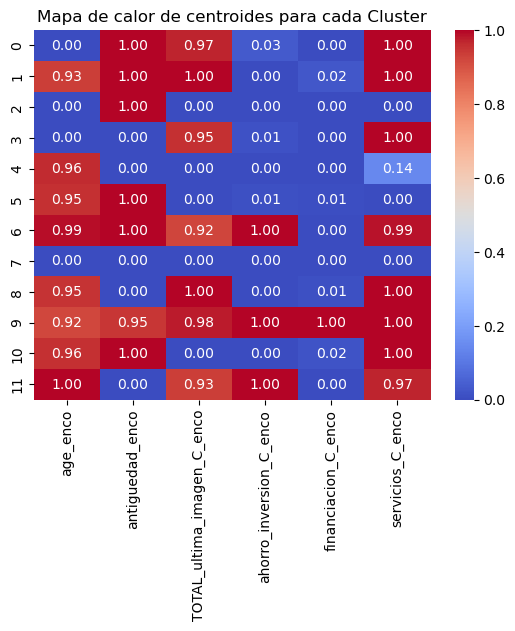

In [79]:
centroides_booleanos = pd.DataFrame(df_normalizado[:, [i for i in range(len(df.columns[1:-1]))]], columns=df.columns[1:-1])

sns.heatmap(centroides_booleanos, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Mapa de calor de centroides para cada Cluster')
plt.show()

#### Análisis de las variables

In [80]:
import matplotlib.pyplot as plt

# definimos una funcion para poder hacer exploracion visual de los distintos cluster
def graficar_por_cluster(lista):
    grouped_df = df_uncoded.groupby('cluster_group')[lista].value_counts().unstack() # agrupamos por cluster y contamos valores

      # Calcula el número de filas y columnas necesarias para los subgráficos
    num_clusters = len(grouped_df)
    num_rows = 2
    num_cols = num_clusters // 2

    # Graficar los histogramas para cada cluster en dos filas
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4 * num_rows))

    for i, (cluster, counts) in enumerate(grouped_df.iterrows()):
        row = i // num_cols
        col = i % num_cols
        counts.plot(kind='bar', ax=ax[row, col], color='skyblue', edgecolor='black')
        ax[row, col].set_title(f'{lista}. Cluster {cluster}')
        ax[row, col].set_xlabel(lista)
        ax[row, col].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()




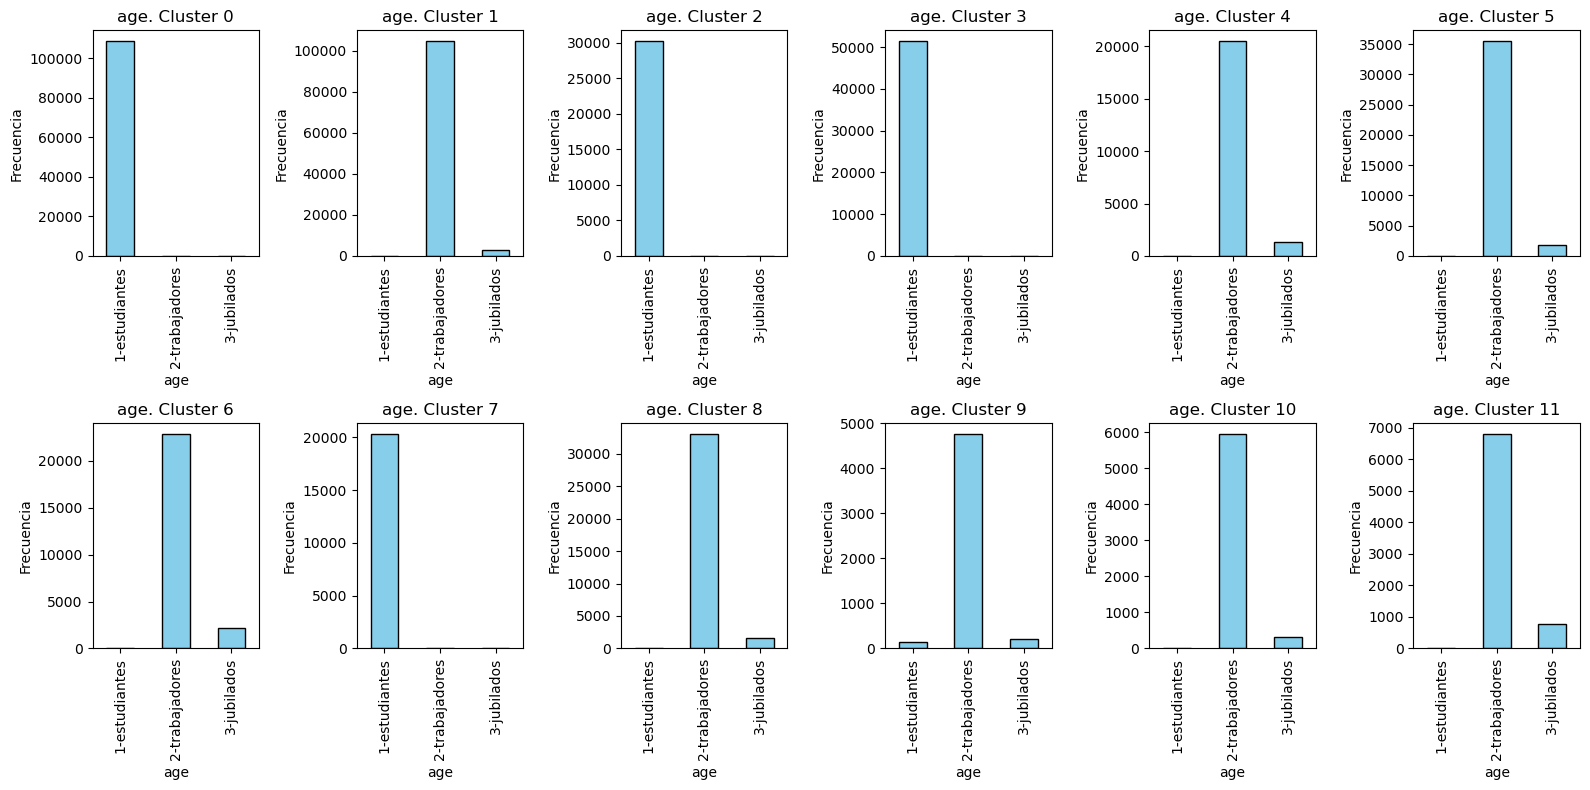

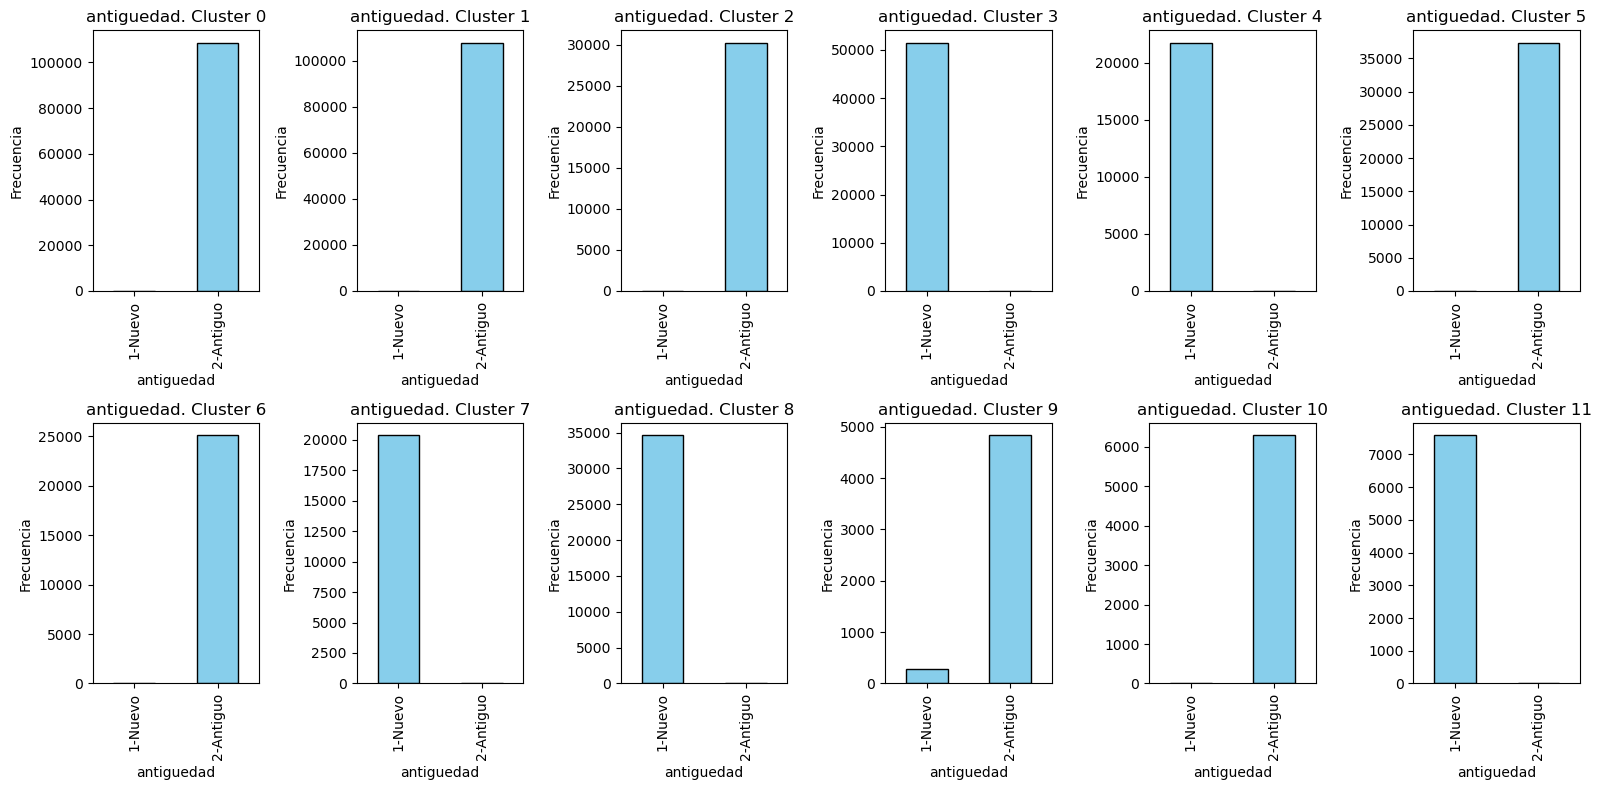

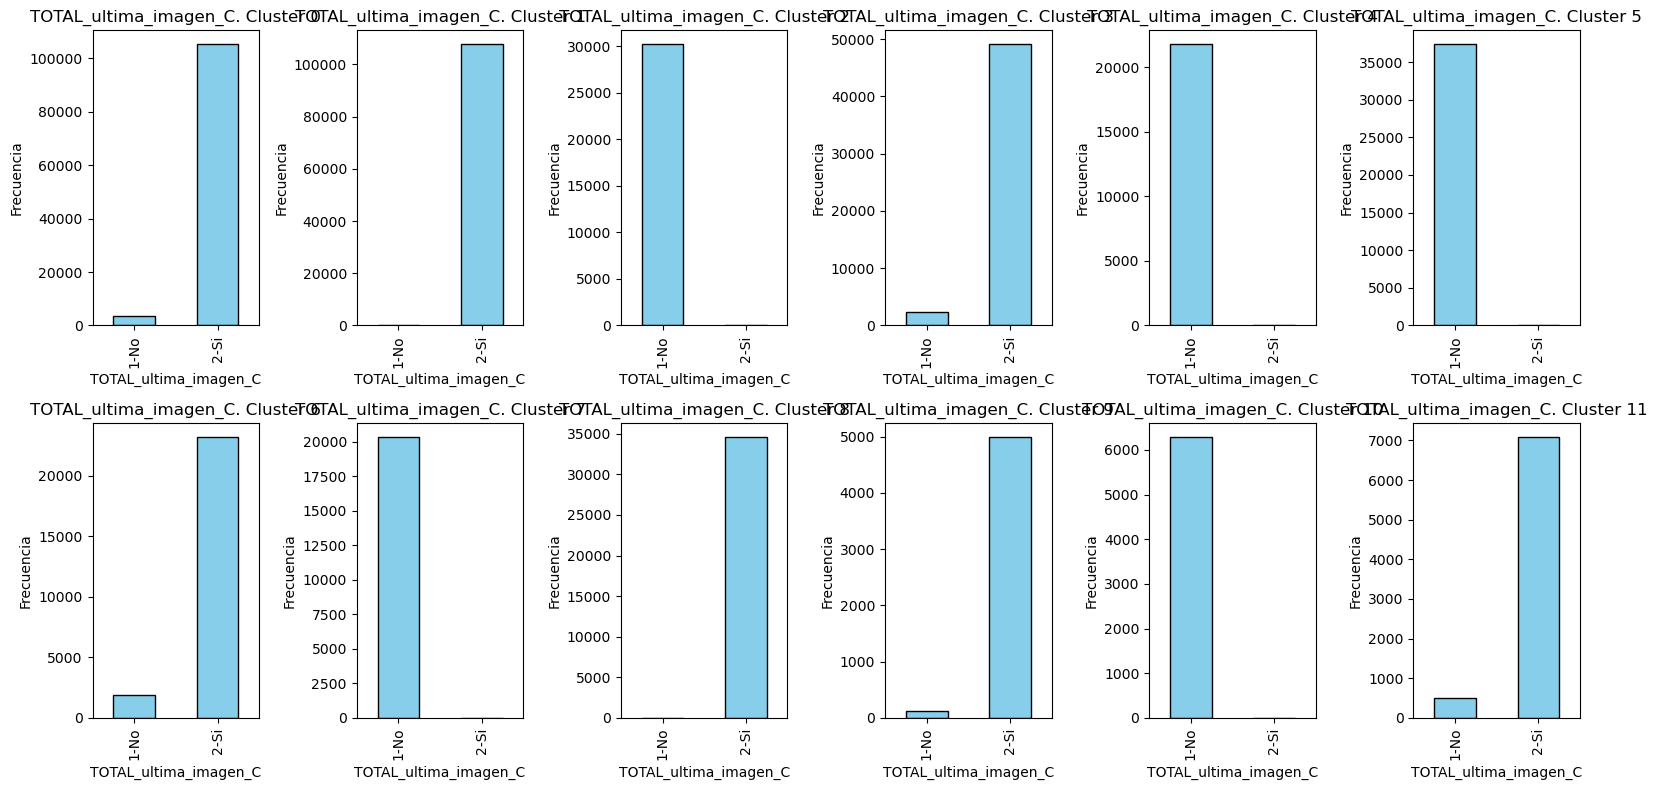

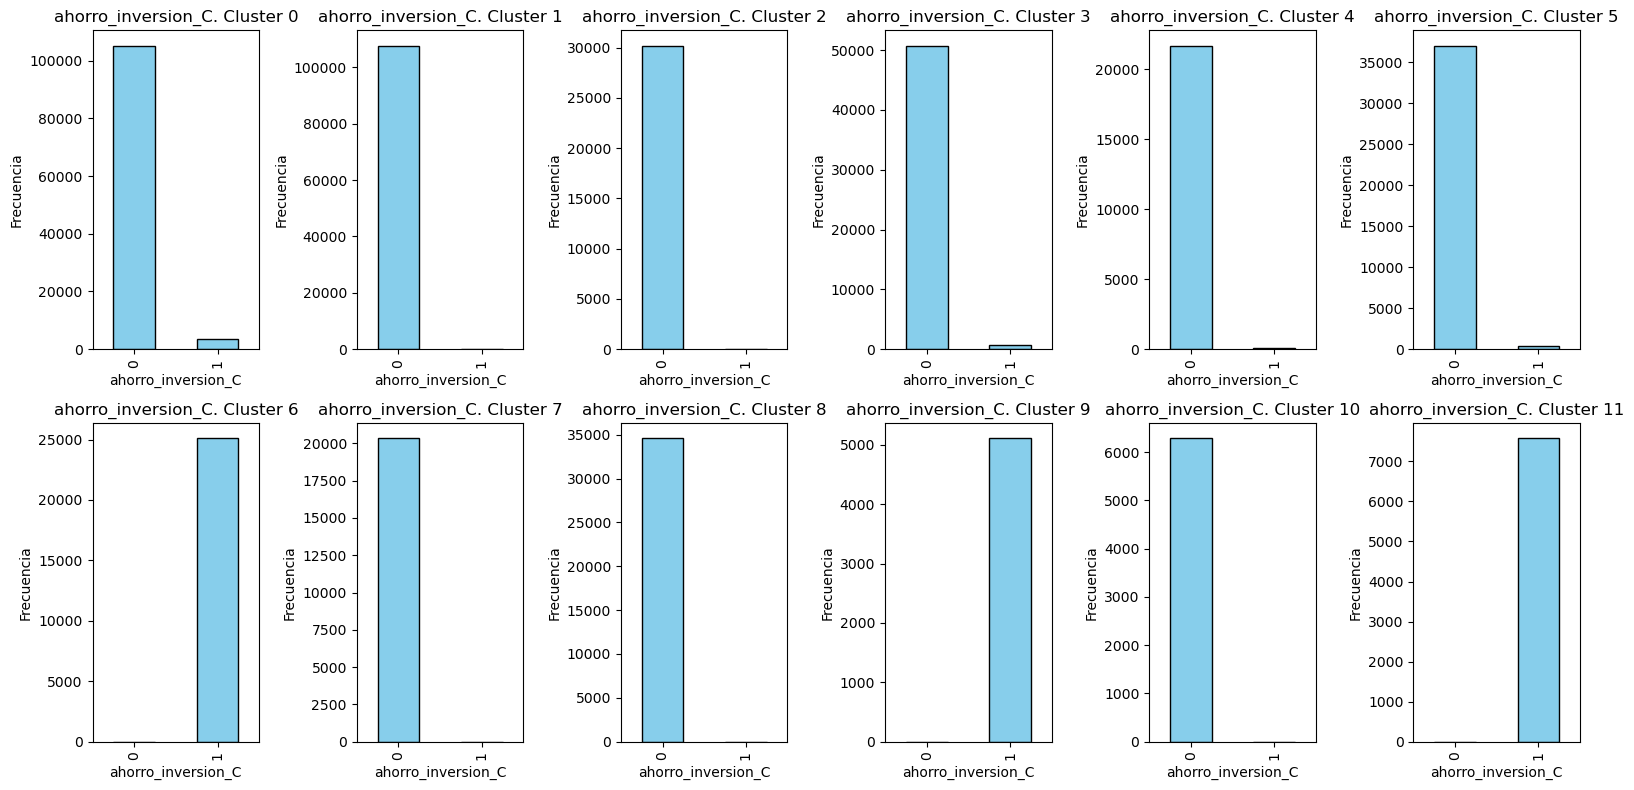

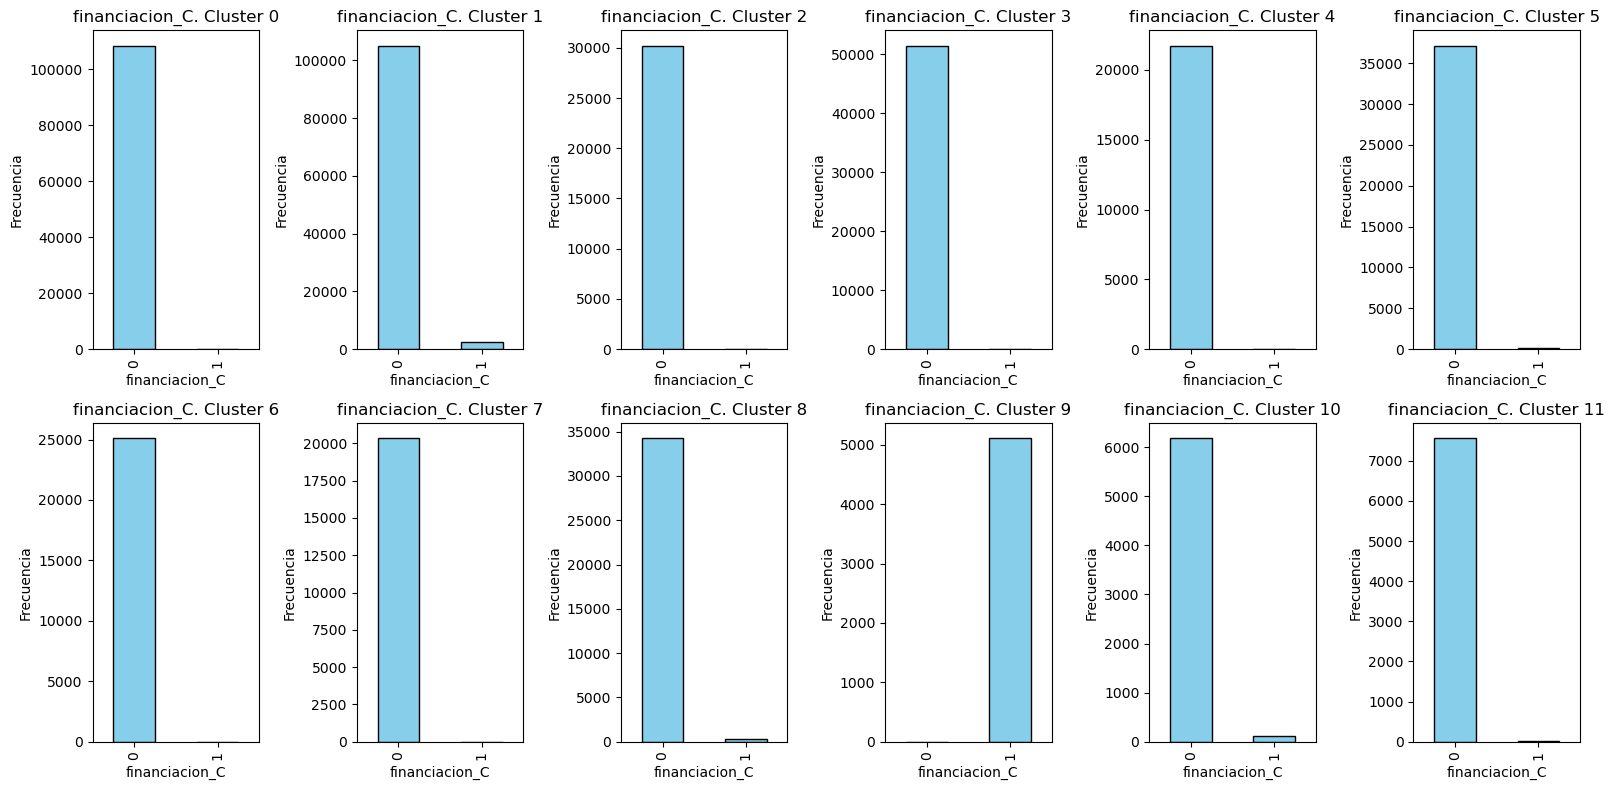

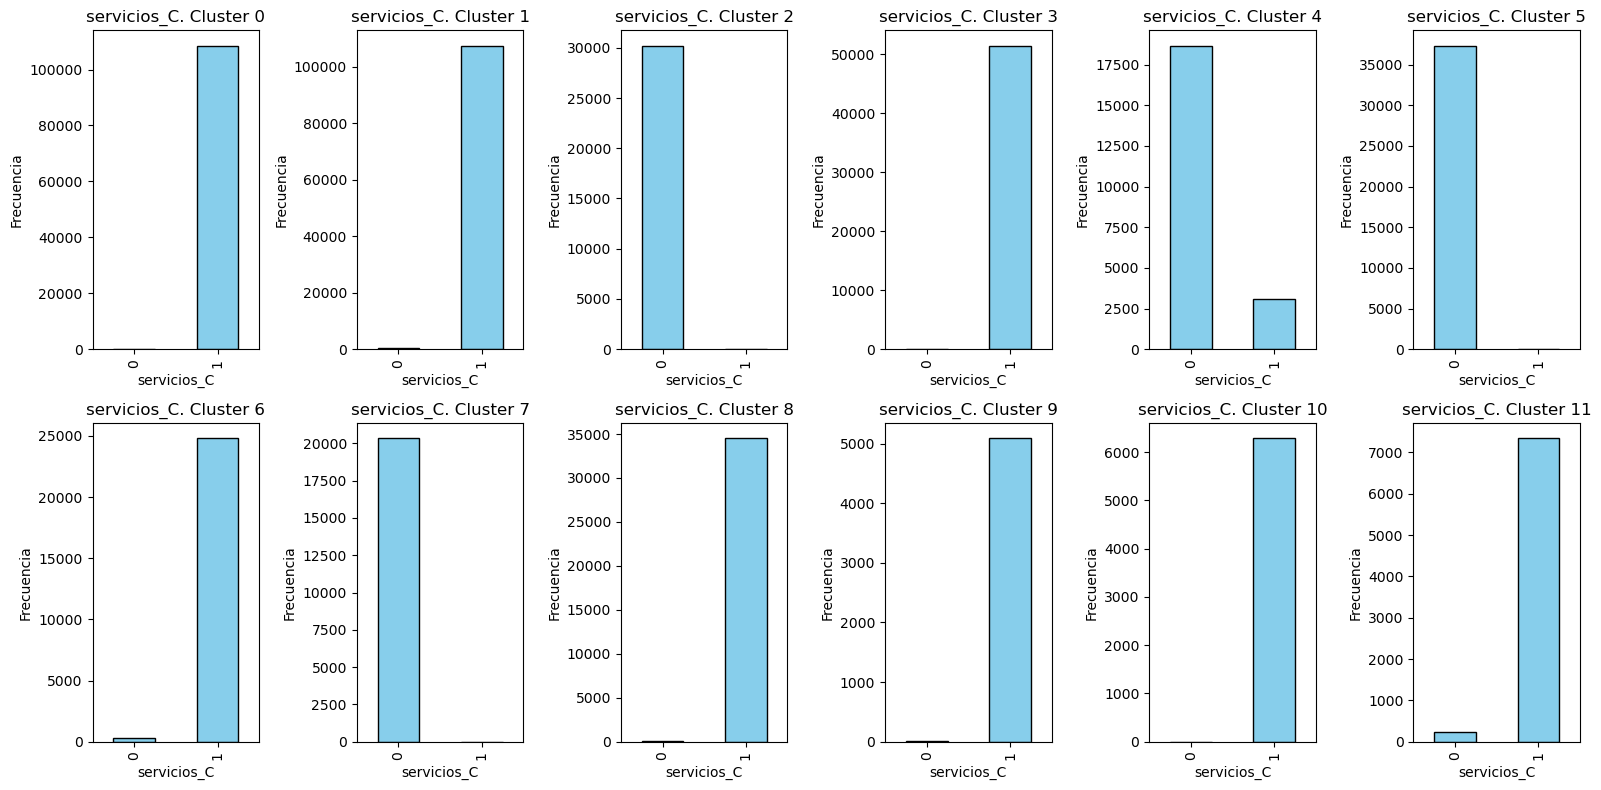

[None, None, None, None, None, None]

In [81]:

# Ejemplo de uso
[graficar_por_cluster(x) for x in df_uncoded.columns[1:-1]]


In [82]:
# definimos una funcion para poder hacer exploracion visual de los distintos cluster
def graficar_por_variable(lista):
    grouped_df = df_uncoded.groupby(lista)['cluster_group'].value_counts().unstack() # agrupamos por producto y contamos valores por cluster

    max_freq = grouped_df.max().max() # ponemos la misma escala a cada cluster para poder comparar

    # Graficar los histogramas para cada cluster
    fig, ax = plt.subplots(nrows=1, ncols=len(grouped_df), figsize=(4 * len(grouped_df), 4))

    for i, (cluster, counts) in enumerate(grouped_df.iterrows()):
        counts.plot(kind='bar', ax=ax[i], color='skyblue', edgecolor='black')
        ax[i].set_title(f'{lista}. Categoría {cluster}')
        ax[i].set_xlabel('Cluster')
        ax[i].set_ylabel('Frecuencia')
        ax[i].set_ylim(0, max_freq)

    plt.tight_layout()
    plt.show()

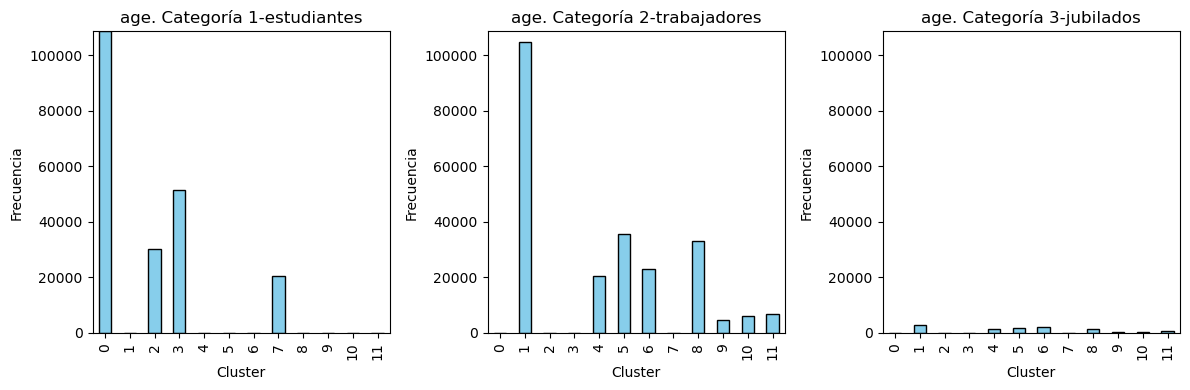

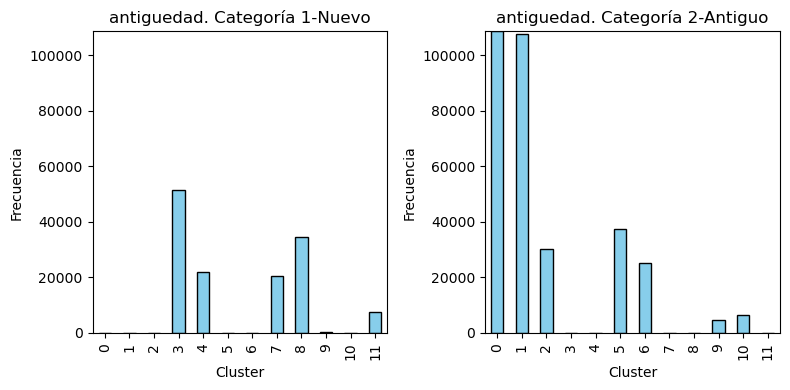

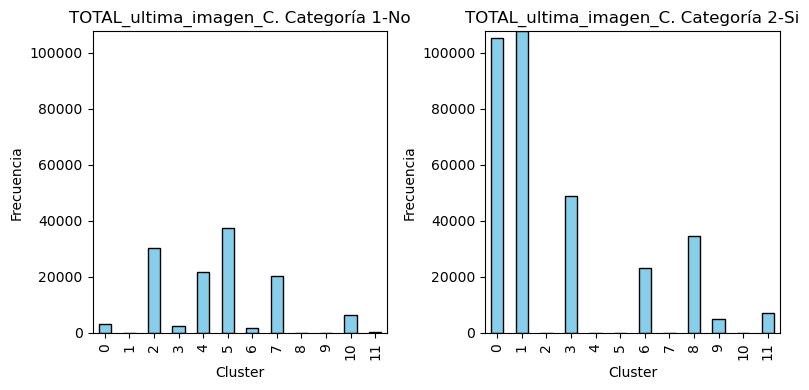

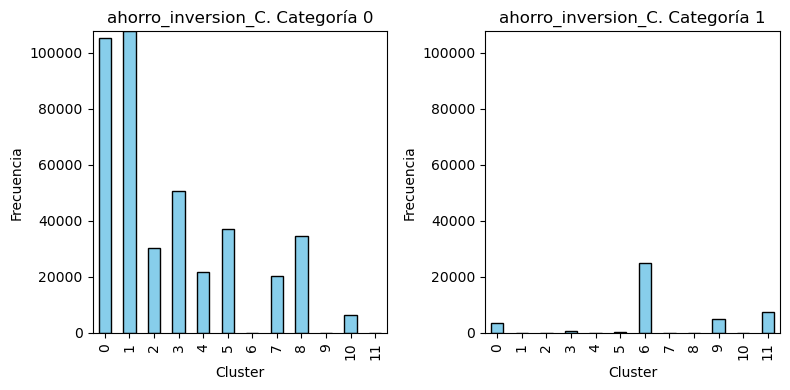

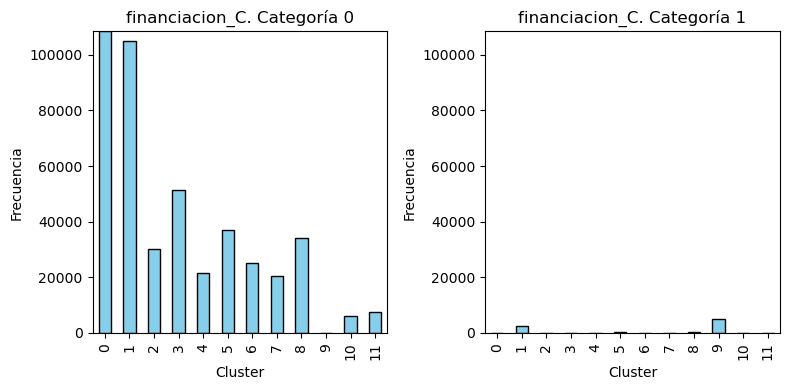

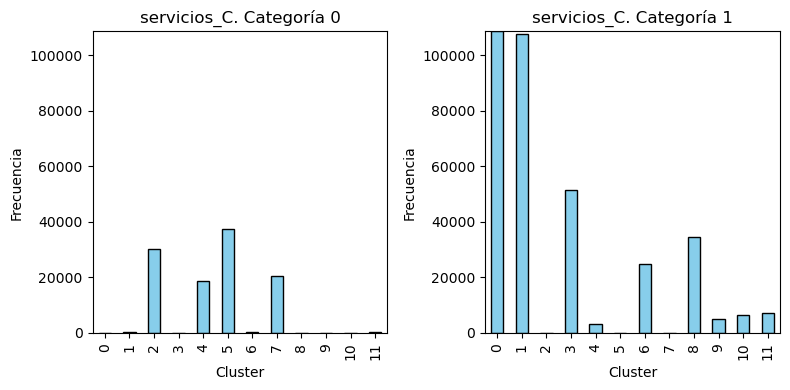

[None, None, None, None, None, None]

In [83]:
[graficar_por_variable(columna) for columna in df_uncoded.columns[1:-1]]

In [84]:
# Lista de nombres de cluster
nombres_clusters = [
    "Estudiante Activo Financieramente",
    "Trabajador Activo Financieramente",
    "Estudiante Pasivo",
    "Estudiante Nuevo Activo Financieramente",
    "Trabajador Nuevo Pasivo",
    "Trabajador Antiguo Pasivo",
    "Trabajador Inversionista",
    "Estudiante Nuevo Pasivo",
    "Trabajador Nuevo Activo Financieramente",
    "Trabajador Inversionista Activo Financieramente",
    "Trabajador Antiguo Pasivo Financieramente",
    "Trabajador Inversionista Activo Bancariamente"
]

# Crear un DataFrame
df_relacion_clusters = pd.DataFrame({
    'Nombre del Cluster': nombres_clusters,
    'Número del Cluster': range(len(nombres_clusters))
})

# Mostrar el DataFrame
print(df_relacion_clusters)


                                 Nombre del Cluster  Número del Cluster
0                 Estudiante Activo Financieramente                   0
1                 Trabajador Activo Financieramente                   1
2                                 Estudiante Pasivo                   2
3           Estudiante Nuevo Activo Financieramente                   3
4                           Trabajador Nuevo Pasivo                   4
5                         Trabajador Antiguo Pasivo                   5
6                          Trabajador Inversionista                   6
7                           Estudiante Nuevo Pasivo                   7
8           Trabajador Nuevo Activo Financieramente                   8
9   Trabajador Inversionista Activo Financieramente                   9
10        Trabajador Antiguo Pasivo Financieramente                  10
11    Trabajador Inversionista Activo Bancariamente                  11


In [85]:
df_clusters = df_uncoded.merge(df_relacion_clusters, left_on='cluster_group', right_on='Número del Cluster')

In [86]:
df_clusters

,pk_cid,age,antiguedad,TOTAL_ultima_imagen_C,ahorro_inversion_C,financiacion_C,servicios_C,cluster_group,Nombre del Cluster,Número del Cluster
0,15891,2-trabajadores,1-Nuevo,1-No,0,0,1,4,Trabajador Nuevo Pasivo,4
1,16063,2-trabajadores,1-Nuevo,1-No,0,0,0,4,Trabajador Nuevo Pasivo,4
2,19812,2-trabajadores,1-Nuevo,1-No,0,0,0,4,Trabajador Nuevo Pasivo,4
3,25569,3-jubilados,1-Nuevo,1-No,0,0,0,4,Trabajador Nuevo Pasivo,4
4,26303,3-jubilados,1-Nuevo,1-No,0,0,0,4,Trabajador Nuevo Pasivo,4
...,...,...,...,...,...,...,...,...,...,...
456237,1552978,1-estudiantes,1-Nuevo,2-Si,0,0,1,3,Estudiante Nuevo Activo Financieramente,3
456238,1553006,1-estudiantes,1-Nuevo,2-Si,0,0,1,3,Estudiante Nuevo Activo Financieramente,3
456239,1553014,1-estudiantes,1-Nuevo,2-Si,0,0,1,3,Estudiante Nuevo Activo Financieramente,3
456240,1553296,1-estudiantes,1-Nuevo,2-Si,0,0,1,3,Estudiante Nuevo Activo Financieramente,3


In [87]:
df_clusters['Cluster'] = df_clusters['Número del Cluster'].astype('str') + '-' + df_clusters['Nombre del Cluster']

In [88]:
df_clusters['Cluster'].value_counts()

0-Estudiante Activo Financieramente                  108608
1-Trabajador Activo Financieramente                  107705
3-Estudiante Nuevo Activo Financieramente             51474
5-Trabajador Antiguo Pasivo                           37361
8-Trabajador Nuevo Activo Financieramente             34621
2-Estudiante Pasivo                                   30226
6-Trabajador Inversionista                            25125
4-Trabajador Nuevo Pasivo                             21776
7-Estudiante Nuevo Pasivo                             20357
11-Trabajador Inversionista Activo Bancariamente       7583
10-Trabajador Antiguo Pasivo Financieramente           6292
9-Trabajador Inversionista Activo Financieramente      5114
Name: Cluster, dtype: int64

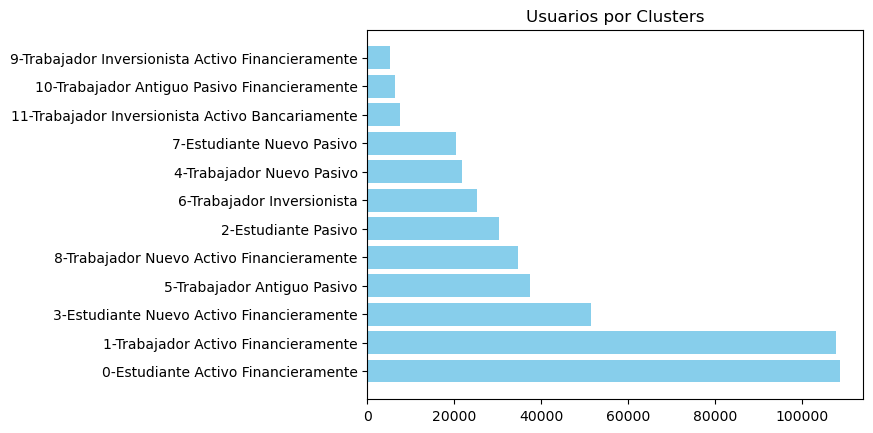

In [89]:
# Visualizamos la distribucion por cluster

# Creamos un DF agrupando por Nombre de cluster
df_cluster_distr = pd.DataFrame(df_clusters['Cluster'].value_counts()).reset_index().rename(columns={'index':'Cluster', 'Cluster':'Conteo'})

# Crear el gráfico de barras horizontales
plt.barh(df_cluster_distr['Cluster'], df_cluster_distr['Conteo'], color='skyblue')
plt.title('Usuarios por Clusters')

# Mostrar el gráfico
plt.show()